# 파이토치 사전훈련 모델 사용
- `torchvision`의 `models`를 활용하여 전이학습

- https://pytorch.org/docs/stable/torchvision/models.html

- 코드 출처: https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html

## modules import

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import time
import os
import copy

## GPU 설정

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [39]:
device

device(type='cuda')

## 데이터 로드 및 확인

In [17]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data -d .

--2020-09-18 10:23:04--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.32.125, 99.86.32.89, 99.86.32.32, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.32.125|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip.1’

hymenoptera_data.zi 100%[===================>]  45.10M  55.1MB/s    in 0.8s    

2020-09-18 10:23:05 (55.1 MB/s) - ‘hymenoptera_data.zip.1’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
replace ./hymenoptera_data/train/ants/0013035.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## 전처리 설정

In [27]:
data_transforms = {"train": transforms.Compose([transforms.RandomResizedCrop(224),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
                   "val": transforms.Compose([transforms.Resize(256),
                                              transforms.CenterCrop(224),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
                   }

In [28]:
data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                         data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: DataLoader(image_datasets[x],
                             batch_size = 4,
                             shuffle = True,
                             num_workers = 4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


In [29]:
print(class_names)

['ants', 'bees']


## 사전훈련된 모델 로드

In [30]:
model_ft = models.resnet18(pretrained = True)

- ImageNet 의 데이터를 훈련한 모델
  - `num_class`가 1000

In [31]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

- 

- 데이터의 클래스 수에 맞게 `out_features` 변경

In [32]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

## 손실함수와 옵티마이저

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr = 0.001, momentum = 0.9)

-  7 에폭마다 0.1씩 학습율 감소

In [52]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma = 0.1)

## 모델 학습

- 학습 함수 정의

In [59]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()   # 이 부부 ㄴ다름
                model.train() 
            else:
                model.eval()  

            running_loss = 0.0
            running_corrects = 0

            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    
    model.load_state_dict(best_model_wts)
    return model

In [60]:
model_ft = train_model(model_ft, criterion, optimizer_ft,
                       exp_lr_scheduler, num_epochs = 25)

Epoch 0/24
----------
train Loss: 0.2832 Acc: 0.8893
val Loss: 0.1410 Acc: 0.9542

Epoch 1/24
----------
train Loss: 0.3212 Acc: 0.8484
val Loss: 0.1552 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.3057 Acc: 0.8730
val Loss: 0.1495 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.3494 Acc: 0.8443
val Loss: 0.1565 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.3194 Acc: 0.8607
val Loss: 0.1567 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.3736 Acc: 0.8033
val Loss: 0.1496 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.3275 Acc: 0.8525
val Loss: 0.1459 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3186 Acc: 0.8607
val Loss: 0.1454 Acc: 0.9608

Epoch 8/24
----------
train Loss: 0.3383 Acc: 0.8648
val Loss: 0.1517 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.3095 Acc: 0.8566
val Loss: 0.1496 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3660 Acc: 0.8320
val Loss: 0.1613 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.3239 Acc: 0.8607
val Loss: 0.1400 Acc: 0.9477

Ep

## 결과 시각화

- 시각화 함수 정의

In [61]:
def imshow(img):
    img = img/ 2 + 0.5
    npimg = img.numpy()
    fig = plt.figure(figsize = (10, 5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [63]:
def visualize_model(model, num_images = 6):

    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title("predicted: {}".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode = was_training)
                    return

        model.train(mode = was_traning)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


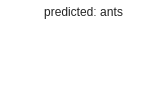

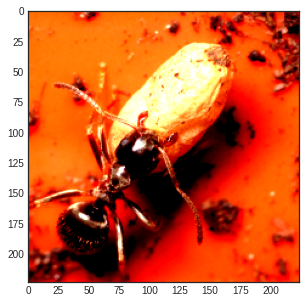

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


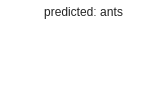

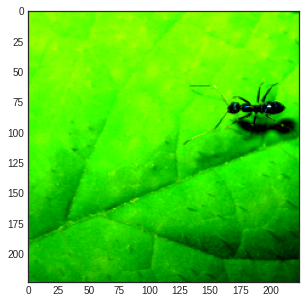

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


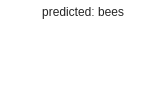

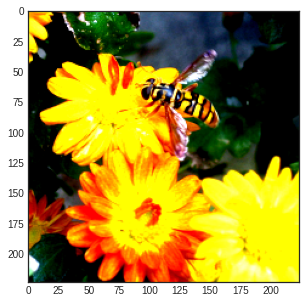

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


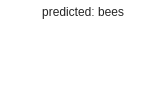

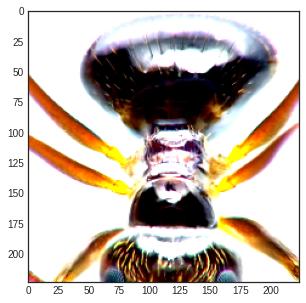

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


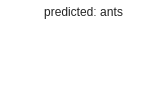

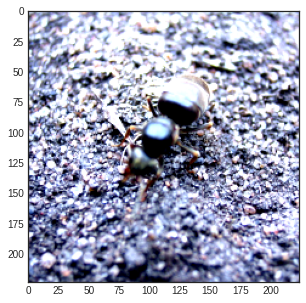

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


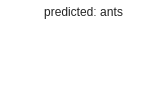

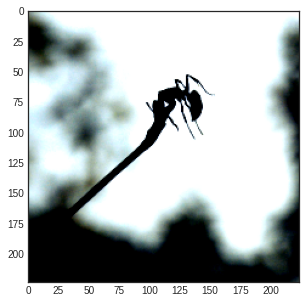

In [64]:
visualize_model(model_ft)

## 고정된 특징 추출기로써의 합성곱 신경망
- 마지막 계층을 제외한 신경망의 모든 부분을 고정

- `requires_grad == False` 로 설정하여 매개변수를 고정하여 backward() 중에 경사도가 계산되지 않도록 한다.



In [65]:
model_conv = torchvision.models.resnet18(pretrained = True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr = 0.001, momentum = 0.9)

exp_lr_schuduler =  lr_scheduler.StepLR(optimizer_conv, step_size = 7, gamma = 0.1)

In [66]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs = 25)

Epoch 0/24
----------
train Loss: 0.6200 Acc: 0.6598
val Loss: 0.3393 Acc: 0.8562

Epoch 1/24
----------
train Loss: 0.4212 Acc: 0.8033
val Loss: 0.4601 Acc: 0.7712

Epoch 2/24
----------
train Loss: 0.4998 Acc: 0.7746
val Loss: 0.1850 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.5972 Acc: 0.7664
val Loss: 0.1564 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.3466 Acc: 0.8402
val Loss: 0.1710 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.5895 Acc: 0.7787
val Loss: 0.2124 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.5430 Acc: 0.7951
val Loss: 0.2737 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.4112 Acc: 0.8320
val Loss: 0.2224 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.5478 Acc: 0.7746
val Loss: 0.4163 Acc: 0.8693

Epoch 9/24
----------
train Loss: 0.6470 Acc: 0.7746
val Loss: 0.2286 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.5609 Acc: 0.7910
val Loss: 0.3147 Acc: 0.8824

Epoch 11/24
----------
train Loss: 0.5118 Acc: 0.7910
val Loss: 0.2609 Acc: 0.9085

Ep

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


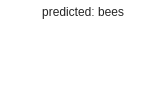

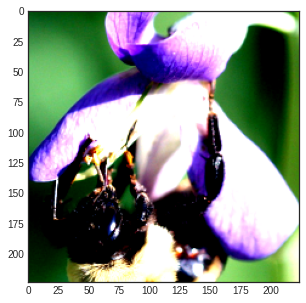

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


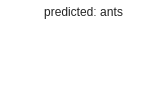

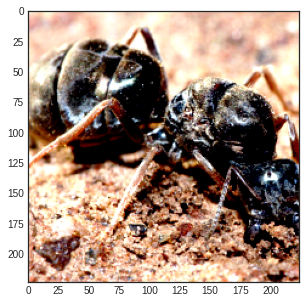

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


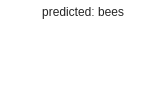

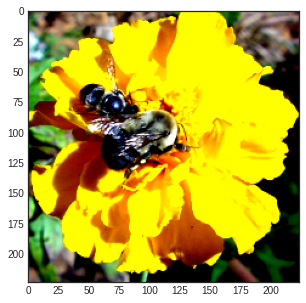

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


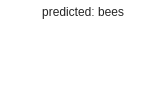

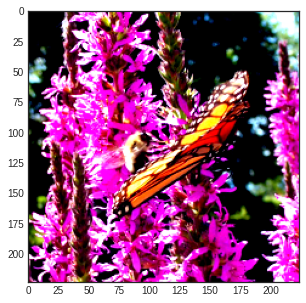

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


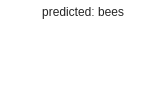

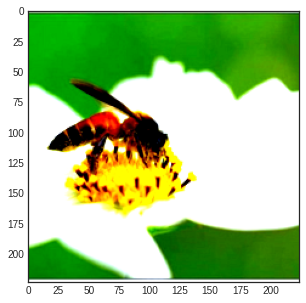

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


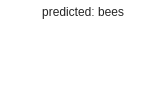

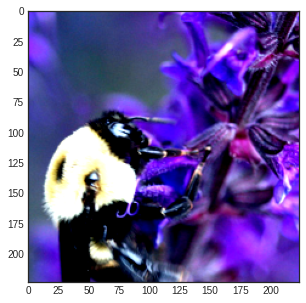

In [68]:
visualize_model(model_conv)